# COGS 118B Final Project
### Authors:
- Michelle Tran
- Christopher Ly

<strong style="color:red">Just for reference for working on GitHub:</strong>
<p style="color:red">Be sure to clear output for the notebook before pushing to the repo, this is to keep commit history clean. You can do this by following the sequence below:</p>

`Cell > All Output > Clear`

In [1]:
import sys
sys.path.insert(0,'src')
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import f1_score, fbeta_score

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sns.set(style='darkgrid')

## Load in data

In [5]:
fp = 'data/telco.csv'

In [6]:
df = pd.read_csv(fp).drop(['customerID'], axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
bf_etl = {
    'Num of features': df.shape[1] - 1, # Churn is a label not a feature
    'Num of datapoints': df.shape[0],
    'Num of not churned': sum(df['Churn']=='No'),
    'Num of churned': sum(df['Churn']=='Yes'),
    '% churned': np.mean(df['Churn']=='Yes')*100
}
summary = pd.DataFrame(bf_etl, index=['Before etl'])
summary

,Num of features,Num of datapoints,Num of not churned,Num of churned,% churned
Before etl,19,7043,5174,1869,26.536987


## Clean data

In [8]:
df = df.drop(df[df['tenure']==0].index).reset_index(drop=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


## Exploratory Data Analysis

In [9]:
df = utils.revert(df)

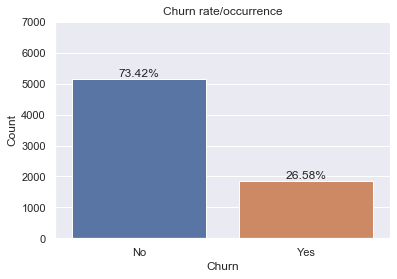

In [10]:
# ref: https://stackoverflow.com/questions/33179122/seaborn-countplot-with-frequencies
ax = sns.countplot(x=df['Churn'])
plt.title('Churn rate/occurrence')
ax.set_ylabel('Count')
ax.set_ylim(0, len(df))

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(100.*y/len(df)), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text
    
plt.show()

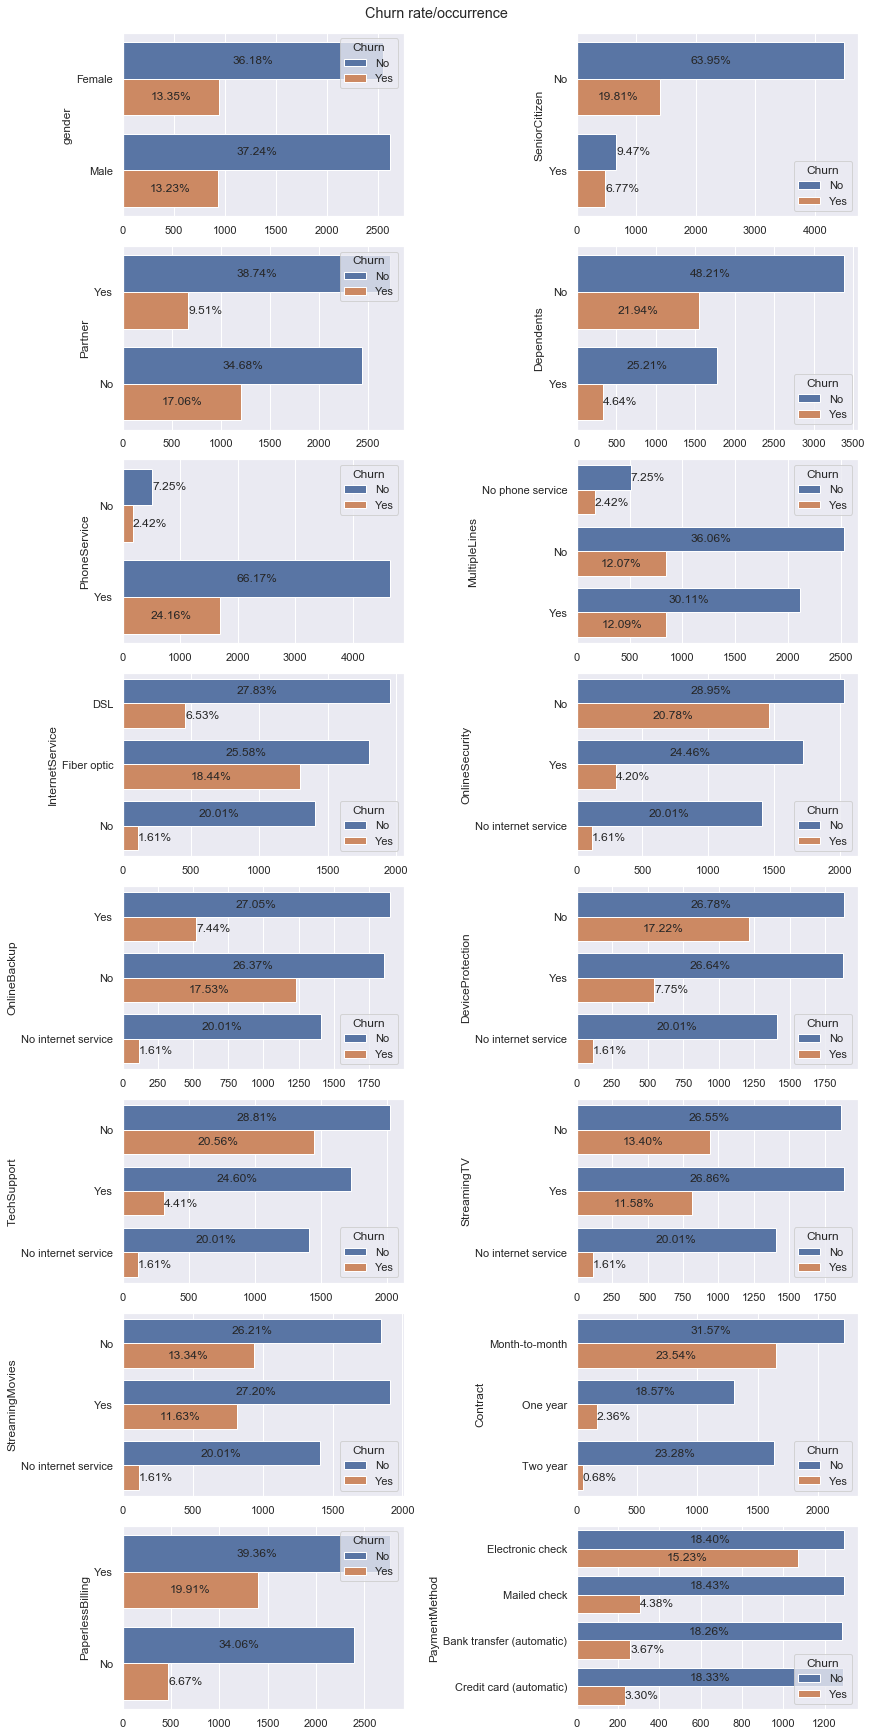

In [11]:
utils.plot_cat(df);

/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


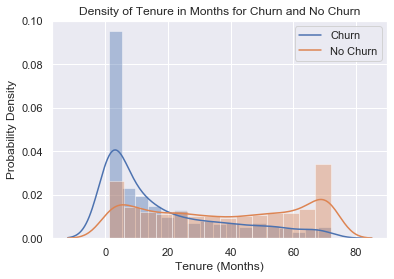

In [12]:
sns.distplot(df['tenure'][df['Churn'] == 'Yes'])
sns.distplot(df['tenure'][df['Churn'] == 'No'])
plt.title('Density of Tenure in Months for Churn and No Churn')
plt.legend(['Churn', 'No Churn'])
plt.xlabel('Tenure (Months)')
plt.ylabel('Probability Density')
plt.show()

/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


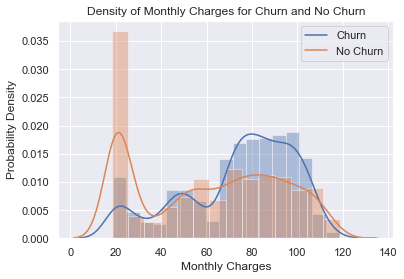

In [13]:
sns.distplot(df['MonthlyCharges'][df['Churn'] == 'Yes'])
sns.distplot(df['MonthlyCharges'][df['Churn'] == 'No'])
plt.title('Density of Monthly Charges for Churn and No Churn')
plt.legend(['Churn', 'No Churn'])
plt.xlabel('Monthly Charges')
plt.ylabel('Probability Density')
plt.show()

/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


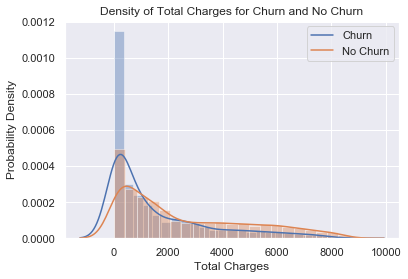

In [14]:
sns.distplot(df['TotalCharges'][df['Churn'] == 'Yes'])
sns.distplot(df['TotalCharges'][df['Churn'] == 'No'])
plt.title('Density of Total Charges for Churn and No Churn')
plt.legend(['Churn', 'No Churn'])
plt.xlabel('Total Charges')
plt.ylabel('Probability Density')
plt.show()

## Data Transformation

In [15]:
addOns = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
def internet_add_ons(r):
    if r['InternetService'] == 'No':
        return 0
    count = 0
    for i in addOns: 
        if r[i] == 'Yes':
            count+=1
    return count

In [16]:
df['InternetAddOns'] = df.apply(internet_add_ons, axis=1)

###### Replaces other distplots, requires `pip install --upgrade seaborn`
utils.plot_num(df);

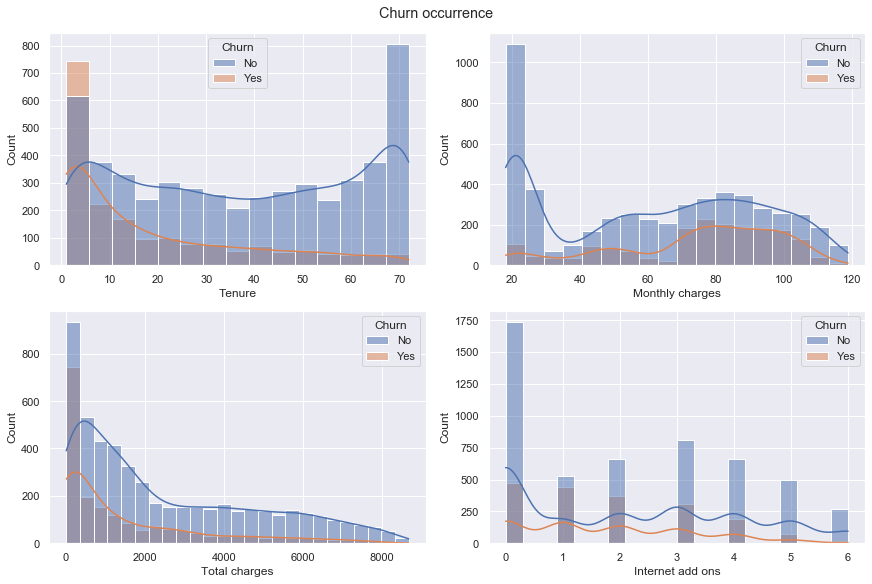

In [17]:
utils.plot_num(df);

/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


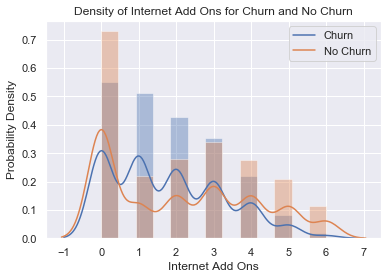

In [18]:
sns.distplot(df['InternetAddOns'][df['Churn'] == 'Yes'])
sns.distplot(df['InternetAddOns'][df['Churn'] == 'No'])
plt.title('Density of Internet Add Ons for Churn and No Churn')
plt.legend(['Churn', 'No Churn'])
plt.xlabel('Internet Add Ons')
plt.ylabel('Probability Density')
plt.show()

In [19]:
df = utils.convert(df)

In [20]:
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')

In [21]:
df_categorical = df.select_dtypes(include=object).drop(addOns, axis=1)
df_numerical = df.select_dtypes(include=np.number).drop(['Churn'], axis=1)

In [22]:
# ref: https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
corr = df_numerical.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,InternetAddOns
gender,1.000,0.002,0.001,-0.010,-0.005,0.008,0.012,0.014,-0.000,0.014
SeniorCitizen,0.002,1.000,0.017,-0.211,0.016,0.008,0.156,0.220,0.102,0.068
Partner,0.001,0.017,1.000,0.452,0.382,0.018,-0.014,0.098,0.319,0.205
Dependents,-0.010,-0.211,0.452,1.000,0.163,-0.001,-0.110,-0.112,0.065,0.030
tenure,-0.005,0.016,0.382,0.163,1.000,0.008,0.005,0.247,0.826,0.495
PhoneService,0.008,0.008,0.018,-0.001,0.008,1.000,0.017,0.248,0.113,-0.092
PaperlessBilling,0.012,0.156,-0.014,-0.110,0.005,0.017,1.000,0.352,0.158,0.183
MonthlyCharges,0.014,0.220,0.098,-0.112,0.247,0.248,0.352,1.000,0.651,0.725
TotalCharges,-0.000,0.102,0.319,0.065,0.826,0.113,0.158,0.651,1.000,0.746
InternetAddOns,0.014,0.068,0.205,0.030,0.495,-0.092,0.183,0.725,0.746,1.000


In [23]:
df_numerical = df.select_dtypes(include=np.number).drop(['Churn','TotalCharges'], axis=1)

In [24]:
X = pd.DataFrame(ohe.fit_transform(df_categorical).todense(), columns=ohe.get_feature_names(df_categorical.columns))
X = pd.concat([df_numerical,X], axis=1)
y = df['Churn']
X.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,InternetAddOns,MultipleLines_No,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,1,29.85,1,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,0,34,1,0,56.95,2,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [25]:
af_etl = {
    'Num of features': X.shape[1],
    'Num of datapoints': X.shape[0],
    'Num of not churned': sum(df['Churn']==0),
    'Num of churned': sum(df['Churn']),
    '% churned': np.mean(df['Churn'])*100
}
summary.append(pd.DataFrame(af_etl, index=['After etl']))

,Num of features,Num of datapoints,Num of not churned,Num of churned,% churned
Before etl,19,7043,5174,1869,26.536987
After etl,22,7032,5163,1869,26.578498


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
af_spt = {
    'Num of datapoints': [X_train.shape[0], X_test.shape[0]],
    'Num of not churned': [sum(y_train==0), sum(y_test==0)],
    'Num of churned': [sum(y_train), sum(y_test)],
    '% churned': [np.mean(y_train)*100, np.mean(y_test)*100]
}
pd.DataFrame(af_spt, index=['Train data', 'Test data'])

,Num of datapoints,Num of not churned,Num of churned,% churned
Train data,5625,4108,1517,26.968889
Test data,1407,1055,352,25.017768


In [28]:
res_ix = ['Logistic Regression', 'SVM', 'AdaBoost']
ave = 'binary'             # average parameter for F1 score
beta = 5                   # beta parameter for Fβ score
scr = 'balanced_accuracy'  # scoring parameter for grid search

In [29]:
res = {
    'Accuracy before grid search': [0,0,0],
    'Accuracy after': [0,0,0],
    'F1 Score': [0,0,0],
    'Fβ Score': [0,0,0]
}

## Regression Model

In [30]:
mdl = LogisticRegression(solver='liblinear')
result = mdl.fit(X_train, y_train)
score = mdl.score(X_test, y_test)*100

In [31]:
param_grid = {'C': [0.001,0.005,0.01,0.05,0.1,0.5,1,10], 
              'penalty' : ['l1', 'l2'],
              'tol' : [1e-4],
              'max_iter' : [100,500,1000]}
gs = GridSearchCV(mdl, param_grid, n_jobs=-1, cv=5, scoring=scr)
gs.fit(X_train, y_train);
mdl = mdl.set_params(**gs.best_params_)

In [32]:
gs.best_params_, gs.best_score_

({'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.0001},
 0.7454598698771819)

In [33]:
res['Accuracy before grid search'][0] = score
res['Accuracy after'][0] = gs.best_estimator_.score(X_test, y_test)*100
res['F1 Score'][0] = f1_score(y_test, mdl.predict(X_test), average=ave)
res['Fβ Score'][0] = fbeta_score(y_test, mdl.predict(X_test), average=ave, beta=beta)

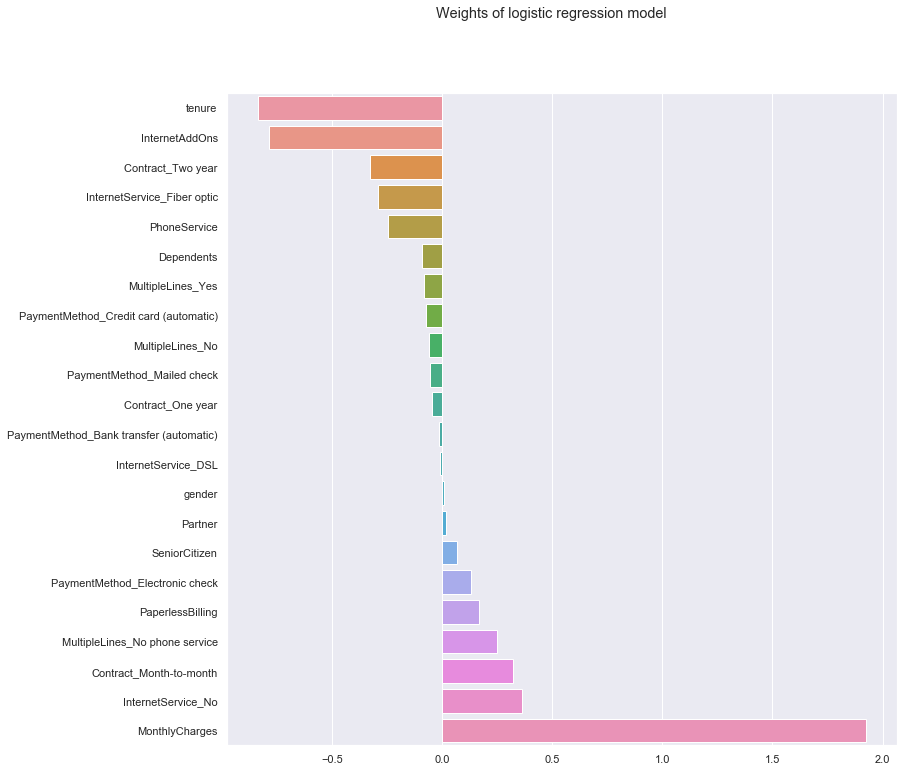

In [34]:
to_sort = {k:v for k,v in zip(X.columns.values,mdl.coef_.reshape((-1,)))}
sort = {k: v for k, v in sorted(to_sort.items(), key=lambda item: item[1])}

plt.figure(figsize=(12,12))
plt.suptitle("Weights of logistic regression model")
sns.barplot(x=[x for _,x in sort.items()], y=[y for y,_ in sort.items()]);

## SVM Model

In [35]:
mdl2 = SVC(gamma='auto')
result2 = mdl2.fit(X_train, y_train)
score2 = result2.score(X_test, y_test)*100

In [36]:
param_grid2 = {'C': [0.001,0.005,0.01,0.05,0.1,0.5,1,10], 
               'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
               'gamma': ['auto', 'scale'],
               'max_iter' : [-1,100,500,1000]}
gs2 = GridSearchCV(result2, param_grid2, n_jobs=-1, cv=5, scoring=scr)
gs2.fit(X_train, y_train);
mdl2 = mdl2.set_params(**gs2.best_params_)

/Users/michelletran/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [37]:
gs2.best_params_, gs2.best_score_

({'C': 0.01, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': 1000},
 0.7483414524290161)

In [38]:
res['Accuracy before grid search'][1] = score2
res['Accuracy after'][1] = gs2.best_estimator_.score(X_test, y_test)*100
res['F1 Score'][1] = f1_score(y_test, mdl2.predict(X_test), average=ave)
res['Fβ Score'][1] = fbeta_score(y_test, mdl2.predict(X_test), average=ave, beta=beta)

## AdaBoost Model

In [39]:
mdl3 = AdaBoostClassifier()
result3 = mdl3.fit(X_train, y_train)
score3 = result3.score(X_test, y_test)*100

In [40]:
param_grid3 = {'n_estimators': [10,25,50,100,250], 
               'learning_rate' : [0.01,0.05,0.1,0.5,1,10]}
gs3 = GridSearchCV(result3, param_grid3, n_jobs=-1, cv=5, scoring=scr)
gs3.fit(X_train, y_train);
mdl3 = mdl3.set_params(**gs3.best_params_)

In [41]:
gs3.best_params_, gs3.best_score_

({'learning_rate': 1, 'n_estimators': 100}, 0.7199095820607496)

In [42]:
res['Accuracy before grid search'][2] = score3
res['Accuracy after'][2] = gs3.best_estimator_.score(X_test, y_test)*100
res['F1 Score'][2] = f1_score(y_test, mdl3.predict(X_test), average=ave)
res['Fβ Score'][2] = fbeta_score(y_test, mdl3.predict(X_test), average=ave, beta=beta)

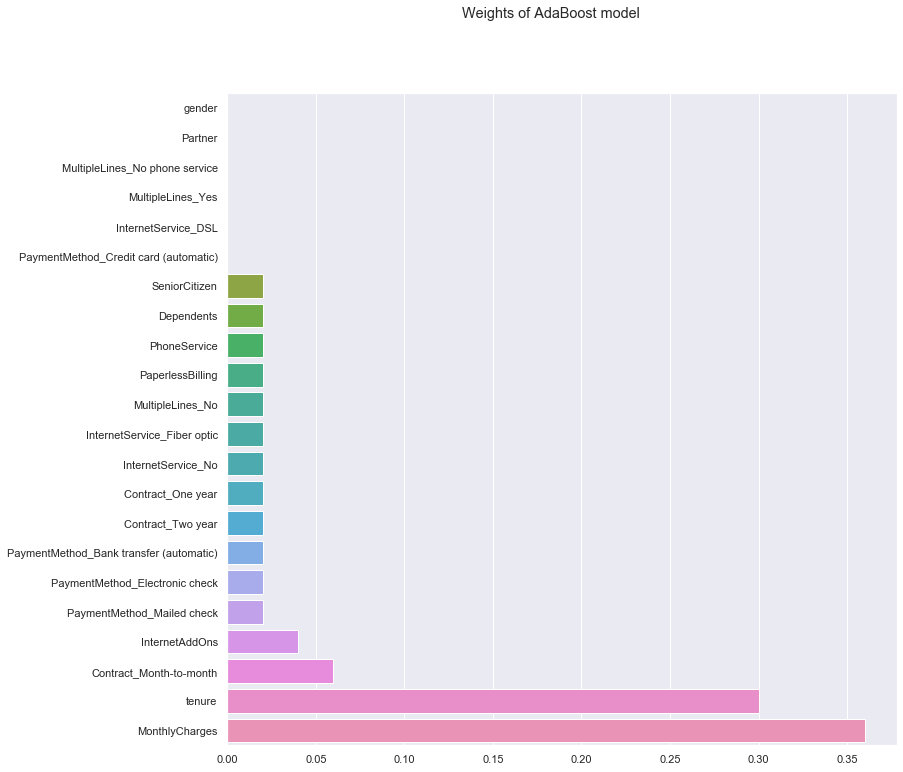

In [43]:
to_sort = {k:v for k,v in zip(X.columns.values,mdl3.feature_importances_)}
sort = {k: v for k, v in sorted(to_sort.items(), key=lambda item: item[1])}

plt.figure(figsize=(12,12))
plt.suptitle("Weights of AdaBoost model")
sns.barplot(x=[x for _,x in sort.items()], y=[y for y,_ in sort.items()]);

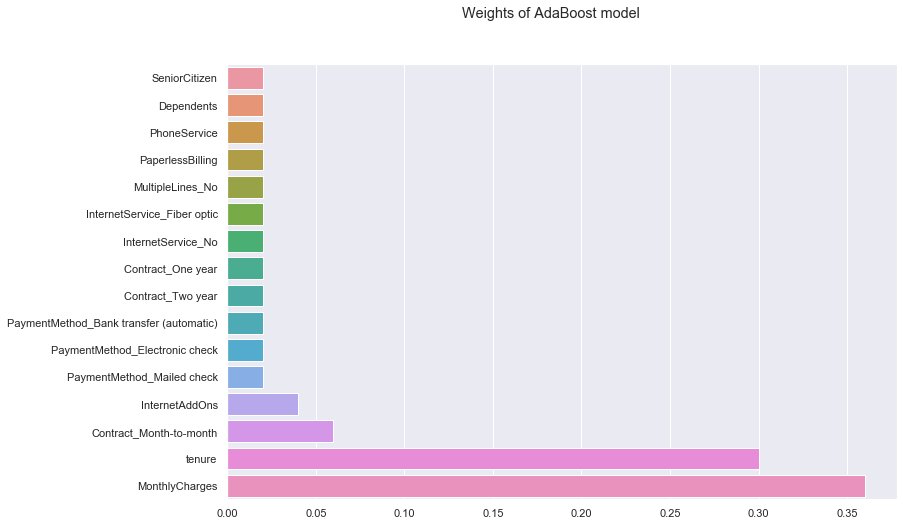

In [44]:
to_sort = {k:v for k,v in zip(X.columns.values,mdl3.feature_importances_)}
sort = {k: v for k, v in sorted(to_sort.items(), key=lambda item: item[1]) if v!=0}

plt.figure(figsize=(12,8))
plt.suptitle("Weights of AdaBoost model")
sns.barplot(x=[x for _,x in sort.items()], y=[y for y,_ in sort.items()]);

## Discussion

In [45]:
pd.DataFrame(res, index=res_ix)

,Accuracy before grid search,Accuracy after,F1 Score,Fβ Score
Logistic Regression,80.028429,77.256574,0.577444,0.547789
SVM,79.459844,56.289979,0.557656,0.806859
AdaBoost,79.175551,78.678038,0.551302,0.514229


In [46]:
np.mean(mdl.predict(X_test) != mdl2.predict(X_test))*100

27.931769722814497

In [47]:
np.mean(mdl.predict(X_test) != mdl3.predict(X_test))*100

8.24449182658138

In [48]:
np.mean(mdl2.predict(X_test) != mdl3.predict(X_test))*100

29.21108742004264